<CENTER><img src="../../images/ATLASOD.gif" style="width:50%"></CENTER>

# Fitting Methods for the Z boson!
This notebook uses ATLAS Open Data http://opendata.atlas.cern to show you the steps to find the Z boson and fit a curve to find the invariant mass.

The whole notebook takes less than an hour to follow through.

Notebooks are web applications that allow you to create and share documents that can contain:
1. live code
2. visualisations
3. narrative text

Notebooks are a perfect platform to develop in Python, since you'll need exactly those 3 things: code, visualisations and narrative text!

By the end of this notebook you will be able to:
1. find the Z boson yourself
2. find the invariant mass of the Z boson using different fits

<CENTER><img src="images/feynman_diagrams/Zee_feynman.png" style="width:40%"></CENTER>

<a id='contents'></a>

Contents: 

[Running a Jupyter notebook](#running) <br />
[To setup everytime](#setupeverytime) <br />
[Where's my data](#fraction) <br />
[Calculate that invariant mass!](#good_leptons) <br />
[Can we process the data yet?!](#load_data) <br />
[Plot Data](#plot_data) <br />
[Your tasks](#tasks) <br />
[Going further](#going_further) <br />

<a id='running'></a>

## Running a Jupyter notebook

To run the whole Jupyter notebook, in the top menu click Cell -> Run All.

To propagate a change you've made to a piece of code, click Cell -> Run All Below.

You can also run a single code cell, by using the keyboard shortcut Shift+Enter.

[Back to contents](#contents)

<a id='setupeverytime'></a>

## To setup everytime
We're going to be using a number of tools to help us:
* urllib: let us download files
* uproot: lets us read .root files typically used in particle physics into data formats used in Python
* pandas: lets us store data as dataframes, a format widely used in Python
* numpy: provides numerical calculations such as histogramming
* matplotlib: common tool for making plots, figures, images, visualisations

In [46]:
import urllib.request # for downloading files
import pandas as pd # to store data as dataframes
import numpy as np # for numerical calculations such as histogramming
import uproot3 # to read .root files as dataframes
import matplotlib.pyplot as plt # for plotting
from scipy.optimize import curve_fit # for fitting
from scipy import special
from IPython.display import Image
from IPython.core.display import HTML 

import warnings
warnings.filterwarnings("ignore")

<a id='fraction'></a>

## Where's my data?

In [10]:
filename = 'data_A.exactly2lep.root'
url = 'https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/exactly2lep/Data/'+filename
urllib.request.urlretrieve(url, filename)

('data_A.exactly2lep.root', <http.client.HTTPMessage at 0x1a550001160>)

[Back to contents](#contents)

<a id='good_leptons'></a>

##  Z Boson Decays

The Z boson is a gauge boson which mediates the weak interaction. Unlike the electrically charged W boson, the Z boson is neutral.

Like the photon, but unlike the W boson, the Z boson mediates an interaction between particles without changing their flavour. While the photon only mediates forces between electrically charged particles, the Z boson also interacts with the uncharged neutrinos.

In 10% of the Z-decays, charged lepton-antilepton pairs are produced. The three possible charged lepton pair types are electron-positron, muon-antimuon, and tau-antitau pairs. Each pair is approximately equally probable.

In order to examine this decay channel, cuts are implemented on the data to ensure only events with exactly 2 leptons of opposite charge are examined.

## Invariant Mass

Invariant mass, or rest mass, is proportional to the inertia of the particle when it is at rest. This is the "m" both in Newton's second law of motion, F=ma, and in Einstein's equation, E=mc2 (in which E must be interpreted as the energy of the particle at rest). 

When a particle decays and hence no longer exists, its mass before the decay can be calculated from the energies and momenta of the decay products. The inferred value of the mass is independent of the reference frame in which the energies and momenta are measured, so that that the mass called "invariant".

## Calculate that invariant mass!

Fill in the missing lines to calculate invariant mass.

1. If the energy of the 2 leptons are *lep_E[0]* and *lep_E[1]*, write the sum of energy, *sumE*
2. Write the sum of x-momentum, *sumpx*
3. Do the same for y and z momenta (*sumpy* and *sumpz*)
4. Now you have the x,y,z components sumpx,sumpy,sumpz. The vector **sump** = (sumpx,sumpy,sumpz). Write the magnitude of total momentum, *sump*.

The invariant mass, *M*, of a parent particle decaying to two daughter particles is related to properties of the daughter particles by the formula:

$$M^2=E^2-p^2,$$

where *E* is the total energy of the daughter particles, and *p* is the magnitude of the vector sum of the momenta of the daughter particles. This is written in natural units with *c*=1.

5. Write *Mll* using this formula for invariant mass

In [2]:
# calculate dilepton invariant mass
def calc_mll(lep_pt,lep_eta,lep_phi,lep_E): # lepton pt,eta,phi,energy
    
    # 0th lepton is [0], next lepton is [1] etc
    # get the energy of 0th lepton by lep_E[0]

    # sumE = sum of energy
    sumE = lep_E[0] + lep_E[1]
    
    px_0 = lep_pt[0]*np.cos(lep_phi[0]) # x-momentum of 0th lepton
    px_1 = lep_pt[1]*np.cos(lep_phi[1]) # x-momentum of 1st lepton
    py_0 = lep_pt[0]*np.sin(lep_phi[0]) # y-momentum of 0th lepton
    py_1 = lep_pt[1]*np.sin(lep_phi[1]) # y-momentum of 1st lepton
    pz_0 = lep_pt[0]*np.sinh(lep_eta[0]) # z-momentum of 0th lepton
    pz_1 = lep_pt[1]*np.sinh(lep_eta[1]) # z-momentum of 1st lepton
    
    # sumpx = sum of x-momenta
    sumpx = px_0 + px_1
    
    # sumpy = sum of y-momenta
    sumpy = py_0 + py_1
    
    # sumpz = sum of z-momenta
    sumpz = py_0 + py_1
    
    # sump = magnitude of total momentum vector. Remember it's a vector!
    sump = ((sumpx)**2 + (sumpy)**2 + (sumpz)**2)**(1/2)
    
    # Mll = invariant mass from M^2 = E^2 - p^2
    Mll = ((sumE)**2 - (sump)**2)**(1/2)
    
    return Mll/1000 # divide by 1000 to go from MeV to GeV

<a id='load_data'></a>

## Can we process the data yet?!

In [3]:
filename = r'C:\Users\Katie\Downloads\data_A.exactly2lep.root'
data_all = pd.DataFrame() # define empty pandas DataFrame to hold all data for this sample
tree = uproot3.open(filename)["mini"] # open the tree called mini
numevents = uproot3.numentries(filename, "mini") # number of events

for data in tree.iterate(['lep_pt','lep_eta','lep_phi','lep_E'], 
                         outputtype=pd.DataFrame, # choose output type as pandas DataFrame
                         entrystop=numevents*0.001): # stop after fraction of events we want to process

    # calculation of 2-lepton invariant mass                                                                                                                                      
    data['mll'] = np.vectorize(calc_mll)(data.lep_pt, data.lep_eta, data.lep_phi, data.lep_E)

    data_all = data_all.append(data) # append dataframe from this batch to the dataframe for the whole sample


[Back to contents](#contents)

<a id='plot_data'></a>

## Function to plot Data

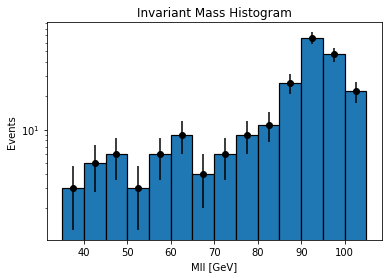

In [4]:
bin_edges = np.arange(start=35, # The interval includes this value
                      stop=110, # The interval doesn't include this value
                      step=5 ) # Spacing between values
bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2 # central values of each bin

# histogram the data
data_x,_ = np.histogram(data_all['mll'], bins=bin_edges) 
plt.hist(data_all['mll'], bins=bin_edges, edgecolor='black', linewidth=1.2)

# statistical error on the data
data_x_errors = np.sqrt(data_x)

# plot the data points
plt.errorbar(x=bin_centres, 
                   y=data_x,
                   yerr=data_x_errors,
                   fmt='ko' ) # 'k' means black and 'o' is for circles

#Axis Titles
plt.xlabel('Mll [GeV]')
plt.ylabel('Events')
plt.title('Invariant Mass Histogram')

# make the y-axis log scale
plt.yscale('log')

Compare this with "Total Cross Section" as a function of "Center of Mass Energy".

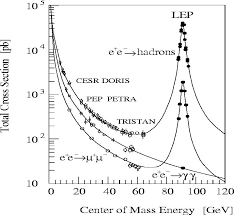

## Fitting Methods: Gaussian Distribution

Fitting a curve to a set of data, such as bins in a hostogram, means trying to find the curve that minimizes the vertical displacement of a data point from the fitted curve.

A Gaussian distribution is defined by two parameters, $\mu$ and $\sigma^2$, namely the mean and the variance. The mean translates the curve left or right, centring it on the value which is expected to occur most frequently. The standard deviation indicates how easy is to deviate from the mean.

By fitting a Gaussian, the centroid of the peak, which represents the invariant mass of the Z boson for our histograms, can be determined by the following:

$$P(x) = Ae^{-\frac{1}{2} (\frac{x-\mu}{\sigma})^2 }$$

Where $\mu$ is the centroid. 

## Fitting a Gaussian Distribution to Extract the Mass

The center of the gaussian fit is 93.94692485837328


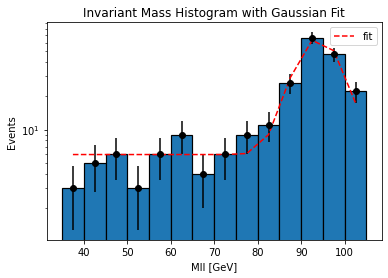

In [6]:
bin_edges = np.arange(start=35, # The interval includes this value
                      stop=110, # The interval doesn't include this value
                      step=5 ) # Spacing between values
bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2 # central values of each bin

# histogram the data
data_x,_ = np.histogram(data_all['mll'], bins=bin_edges ) 
plt.hist(data_all['mll'], bins=bin_edges, edgecolor='black', linewidth=1.2)

# statistical error on the data
data_x_errors = np.sqrt(data_x)

# plot the data points
plt.errorbar(x=bin_centres, 
                   y=data_x, 
                   yerr=data_x_errors,
                   fmt='ko' ) # 'k' means black and 'o' is for circles

# Gaussian Fit Function :
def gauss(x, H, A, mu, sigma):
    return H + A*np.exp(-(x - mu)**2/(2*sigma**2))

#Fitting Parameters
def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt

H, A, mu, sigma = gauss_fit(bin_centres, data_x)

FWHM = 2.35482 * sigma

print('The center of the gaussian fit is', mu)

plt.plot(bin_centres, gauss(bin_centres, *gauss_fit(bin_centres, data_x)), '--r', label='fit')

plt.legend()

First = gauss(bin_centres, *gauss_fit(bin_centres, data_x)) #For a later fit


#Axis Titles
plt.xlabel('Mll [GeV]')
plt.ylabel('Events')
plt.title('Invariant Mass Histogram with Gaussian Fit')

# make the y-axis log scale
plt.yscale('log')
figsize=(8, 6)

<a id='going_further'></a>

## Fitting Methods: Breit-Wigner Distribution

The Breit-Wigner distribution descreases more slowly than a Gaussian, a Gaussian with the same full width half max (FWHM) as the Breit-Wigner distribution would be even narrower. The distribution is defined by the following:

$$P(E) = \frac{k}{(E^2-M^2)^2 + M^2\Gamma^2}$$

where $k = \frac{2\sqrt{2}M\Gamma\gamma}{\pi\sqrt{M^2+\gamma}}$, and $\gamma = \sqrt{M^2(M^2+\Gamma^2)}$.

This distribution can be used to get valuable information from the histogram, much like the Gaussian. E is the center-of-mass energy that produces the resonance, M is the mass of the resonance, and $\Gamma$ is the resonance width (or decay width), related to its mean lifetime according to $\tau$ = $\frac{1}{\Gamma}$.

The form of this Breit–Wigner distribution arises from the propagator of the particle, which has a denominator of the form: $p^2 − M^2 + iM\Gamma$, where $p^2$ is the square of the four-momentum carried by that particle in the Feynman diagram. The propagator in its rest frame then is proportional to the propability amplitude for the particle's decay:

$${\frac{\sqrt {k}}{\left(E^{2}-M^{2}\right)+iM\Gamma }}$$

It is clear that the resulting probability distribution would be proportional to the absolute square of this amplitude. Thus, the probability of producing the resonance at a given energy E is proportional to P(E), so that a plot of the production rate of a particle as a function of energy traces out the shape of the relativistic Breit–Wigner distribution.

## Fitting a Breit–Wigner Distribution to Extract the Mass

http://arpg-serv.ing2.uniroma1.it/patera/didattica/fis_mod/trasp_riv/Glossario/node15.html

The center of the Briet-Wigner fit is 94.07275397230794
The center of the Briet-Wigner fit is 10.654916209004048
The center of the Briet-Wigner fit is 1165.900407370262


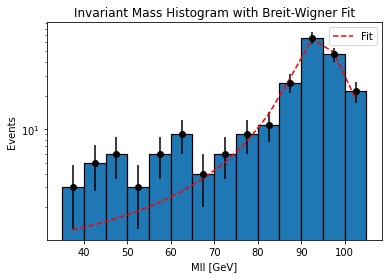

In [61]:
bin_edges = np.arange(start=35, # The interval includes this value
                      stop=110, # The interval doesn't include this value
                      step=5 ) # Spacing between values
bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2 # central values of each bin

# histogram the data
data_x,_ = np.histogram(data_all['mll'], bins=bin_edges )
plt.hist(data_all['mll'], bins=bin_edges, edgecolor='black', linewidth=1.2)

# statistical error on the data
data_x_errors = np.sqrt(data_x)

# plot the data points
plt.errorbar(x=bin_centres, 
                   y=data_x, 
                   yerr=data_x_errors,
                   fmt='ko' ) # 'k' means black and 'o' is for circles

# Breit-Wigner Fit Function :

def relativistic_breit_wigner(x, resonance_mass, width, normalization):
    gamma = np.sqrt(resonance_mass ** 2 * (resonance_mass ** 2 + width ** 2))
    k = 2.0 * np.sqrt(2) * resonance_mass * width * gamma / (np.pi * np.sqrt(resonance_mass ** 2 + gamma))
    return normalization * k / ((x ** 2 - resonance_mass ** 2) ** 2 + resonance_mass ** 2 * width ** 2)

popt, pcov = curve_fit(relativistic_breit_wigner, bin_centres, data_x)

resonance_mass, width, normalization = popt[0], popt[1], popt[2]

plt.plot(bin_centres, relativistic_breit_wigner(bin_centres, popt[0], popt[1], popt[2]), '--r', label='Fit')

print('The center of the Briet-Wigner fit is', popt[0])
print('The center of the Briet-Wigner fit is', popt[1])
print('The center of the Briet-Wigner fit is', popt[2])
plt.legend()

Second = relativistic_breit_wigner(bin_centres, popt[0], popt[1], popt[2]) #For a later fit


#Axis Titles
plt.xlabel('Mll [GeV]')
plt.ylabel('Events')
plt.title('Invariant Mass Histogram with Breit-Wigner Fit')

# make the y-axis log scale
plt.yscale('log')
figsize=(8, 6)

## Fitting Methods: Voigt Distribution

We have seen how a Gaussian is a *pretty good* fit to the data, and how a Breit-Wigner does a better job, and is theoretically a great fit. There is, however, one last fit we can try to improve the accuracy of our result. 

In experiment, the incident beam that produces resonance always has some spread of energy around a central value, this uncertainty follows a Gaussian distribution. 

To account for this we can use a Voigt profile, which is a probability distribution given by a convolution of a Breit-Wigner distribution and a Gaussian distribution. Convolution is a mathematical operation on two functions that produces a third function which expresses how the shape of one is modified by the other. So since our Breit-Wigner fit is being modified by uncertainty modelled by a Gaussian, we can use this to create a really accurate fit!

$${P(E)=\int _{-\infty }^{\infty }{\frac {k}{(E'^{2}-M^{2})^{2}+(M\Gamma )^{2}}}{\frac {1}{\sigma {\sqrt {2\pi }}}}e^{-{\frac {(E'-E)^{2}}{2\sigma ^{2}}}}dE'}$$

## Fitting a Voigt Distribution (Convolution) to Extract the Mass

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


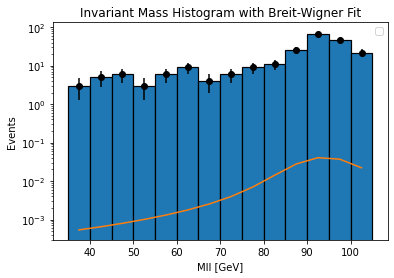

In [60]:
bin_edges = np.arange(start=35, # The interval includes this value
                      stop=110, # The interval doesn't include this value
                      step=5 ) # Spacing between values
bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2 # central values of each bin

# histogram the data
data_x,_ = np.histogram(data_all['mll'], bins=bin_edges )
plt.hist(data_all['mll'], bins=bin_edges, edgecolor='black', linewidth=1.2)

# statistical error on the data
data_x_errors = np.sqrt(data_x)

# plot the data points
plt.errorbar(x=bin_centres, 
                   y=data_x, 
                   yerr=data_x_errors,
                   fmt='ko' ) # 'k' means black and 'o' is for circles

# Voigt Profile- Convolution:

def _1Voigt(x, ampG1, cenG1, sigmaG1, ampL1, cenL1, widL1):
    return (ampG1*(1/(sigmaG1*(np.sqrt(2*np.pi))))*(np.exp(-((x-cenG1)**2)/((2*sigmaG1)**2)))) +\
              ((ampL1*widL1**2/((x-cenL1)**2+widL1**2)) )

dx = bin_centres[1] - bin_centres[0]

#plt.plot(bin_centres, _1Voigt(bin_centres, A, mu, sigma, normalization, resonance_mass, width)/dx, '--r', label='Fit')

#func = special.voigt_profile(bin_centres, sigma, width)
#plt.plot(bin_centres,func)

from astropy import modeling

v1 = modeling.functional_models.Voigt1D(x_0=resonance_mass, amplitude_L=2/(np.pi*width), fwhm_L=width, fwhm_G=sigma*2*(2*np.log(2))**(1/2))
plt.plot(bin_centres, v1(bin_centres))

#print('The center of the Briet-Wigner fit is', popt[0])
plt.legend()

#Second = relativistic_breit_wigner(bin_centres, popt[0], popt[1], popt[2]) #For a later fit


#Axis Titles
plt.xlabel('Mll [GeV]')
plt.ylabel('Events')
plt.title('Invariant Mass Histogram with Breit-Wigner Fit')

# make the y-axis log scale
plt.yscale('log')
figsize=(8, 6)

## Fit Comparison!

In [25]:
Image(url= "https://scipython.com/static/media/examples/E8/voigt.png")

[Back to contents](#contents)